# Modeling and Simulation in Python-Project 1


Dhara Patel and Corinne Wilklow 

Copyright 2018 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [33]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *

from pandas import read_html

print('done')

done


In [34]:
# Importing Population Data
filename = 'data/US_Population_data.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table = tables[3]
table1 = table[1910.0:2010.0]
table1.columns = ['population']
print(table1)

             population
Censusyear             
1910.0       92228496.0
1920.0      106021537.0
1930.0      123202624.0
1940.0      132164569.0
1950.0      151325798.0
1960.0      179323175.0
1970.0      203211926.0
1980.0      226545805.0
1990.0      248709873.0
2000.0      281421906.0
2010.0      308745538.0


<bk> 
    The state: initial child population, initial United States population

The system: birth rates, child mortality rates, mature rates(birth rates 18 years prior)

Metrics: annual child population

In [35]:
def plot_results(population, childseries, title):
    """Plot the estimates and the model.
    
    population: TimeSeries of historical population data
    childseries: TimeSeries of child population estimates
    title: string
    """
    plot(population, ':', label='US Population')
    if len(childseries):
        plot(childseries, color='gray', label='US Children')
       # plot(ratioseries, label='Ratio of children')
    decorate(xlabel='Year', 
             ylabel='Population (million)',
             title=title)

In [36]:
def plot_ratio(ratioseries, title):
    """Plot the estimates and the model.
    
    population: TimeSeries of historical population data
    childseries: TimeSeries of child population estimates
    title: string
    """
    if len(ratioseries):
        plot(ratioseries, color='gray', label='Ratio of Children')
       # plot(ratioseries, label='Ratio of children')
    decorate(xlabel='Year', 
             ylabel='Population (million)',
             title=title)

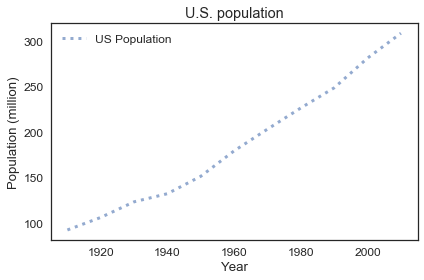

In [37]:
population = table1.population / 1e6
childseries = TimeSeries()
ratioseries = TimeSeries()
plot_results(population, childseries, 'U.S. population')

## Why is the proportion of children in the United States decreasing?
<bk>
    Over the past two decades, the United States population grew by about 20%. During the same time frame, the nation’s child population grew by only 5%. The population all around the world is aging, and children represent a smaller and smaller share of it. There are other countries in which this decrease is more dramatic, such as Germany or Japan which no longer have a positive natural increase in population. A decreasing proportion of children is a problem because the issue will only compound over time, until the population as a whole begins to decline. 
<bk>
The decreasing ratio of children could be due to several factors: declining fertility rates, an aging population, and a drop in net immigration levels. Our model focuses on the effects of fertility rates and child mortality rates on proportions of children in the US. Specifically, if we sweep birthrates and child mortality rates, what effects does that have on the population as a whole? Could changing birth rates and death rates account for the entirety of the changing demographics? We will use US Census data from 1910-2010 to compare to our results.


In [38]:
#sweeping both the mortality rate and the birth rate will make the model more accurate 
birthrate = [29.06, 25.03, 19.22, 22.63, 24.86, 20.33, 15.57, 15.83, 15.08, 13.97]
deathrate = linspace(0.0065, 0.0031, 10)
maturerate = [31.5, 29.06, 25.03, 19.22, 22.63, 24.86, 20.33, 15.57, 15.83, 15.08]
print(birthrate)
print(deathrate)
print(maturerate)

[29.06, 25.03, 19.22, 22.63, 24.86, 20.33, 15.57, 15.83, 15.08, 13.97]
[0.0065     0.00612222 0.00574444 0.00536667 0.00498889 0.00461111
 0.00423333 0.00385556 0.00347778 0.0031    ]
[31.5, 29.06, 25.03, 19.22, 22.63, 24.86, 20.33, 15.57, 15.83, 15.08]


In [39]:
state = State(children = 47.3, t_pop= 151325798.0/1e6, ratio = 47.3/151325798.0/1e6)

,values
children,4.730000e+01
t_pop,1.513258e+02
ratio,3.125706e-13


Parameters:

In [40]:
system = System(birthrate = birthrate,
                maturerate = maturerate,
                deathrate = deathrate,
                t_0 = 1910.0,
                t_end = 2010.0,
                state=state)

,values
birthrate,"[29.06, 25.03, 19.22, 22.63, 24.86, 20.33, 15...."
maturerate,"[31.5, 29.06, 25.03, 19.22, 22.63, 24.86, 20.3..."
deathrate,"[0.0065, 0.006122222222222222, 0.0057444444444..."
t_0,1910
t_end,2010
state,children 4.730000e+01 t_pop 1.513258e...


Our update function computes the updated state of these parameters at the end of each ten year increment. 

In [41]:
def update_func1(state, t, system):
    t_pop=151325798.0

    if t == 1910:
        i = int((t-1910)/10)
    else: 
        i = int((t-1910)/10 - 1)
    
    mrate = system.maturerate 
    brate = system.birthrate
    drate = system.deathrate

    
    births = brate[i]/100 * state.children #metric
    maturings = mrate[i]/100 * state.children #metric
    deaths = drate[i]/100 * state.children #metric

    population = state.children + births - maturings - deaths
        #print('children',children)
        
    return State(children=population)

To test our update function, we'll input the initial condition:

In [42]:
update_func1(state,system.t_0,system)

,values
children,46.142805


In [43]:
def run_simulation(state, system, update_func):
    """Simulate the system using any update function.
    
    state: initial State object
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries of Ratios
    """
    #t_pop=151325798.0
    results = TimeSeries()
    state = system.state
    results[system.t_0] = state.children
    
    
    for t in linrange(1910.0, 2020.0):
        if t%10 == 0:
            '''if t == 1910:
                i = int((t-1910)/10)
            else: 
                i = int((t-1910)/10 - 1)'''
            state.children = update_func1(state, t, system)
            results[t] = state.children
        
    return results

In [44]:
print(population[1910])

92.228496


In [45]:
'''def update_ratio(state, t, system):
    childpop = state.children
    popu = population[t]
    
    ratio = childpop/popu 
    return State(ratio = ratio)
                 
def run_ratio(state, system, update_ratio):
    results = TimeSeries()
    results[system.t_0] = state.ratio
    
    for t in linrange(1910.0, 2020.0):
        if t%10 == 0:
            results[t] = update_ratio(state, t, system)'''

'def update_ratio(state, t, system):\n    childpop = state.children\n    popu = population[t]\n    \n    ratio = childpop/popu \n    return State(ratio = ratio)\n                 \ndef run_ratio(state, system, update_ratio):\n    results = TimeSeries()\n    results[system.t_0] = state.ratio\n    \n    for t in linrange(1910.0, 2020.0):\n        if t%10 == 0:\n            results[t] = update_ratio(state, t, system)'

In [46]:
childseries = run_simulation(state, system, update_func1)

for t in linrange(1910.0, 2020.0):
    if t%10 == 0:
        ratioseries[t] = childseries[t]/population[t]

print(ratioseries)

1910    0.500310
1920    0.424573
1930    0.350618
1940    0.307835
1950    0.278010
1960    0.239825
1970    0.202035
1980    0.172592
1990    0.157614
2000    0.138243
2010    0.124606
dtype: float64


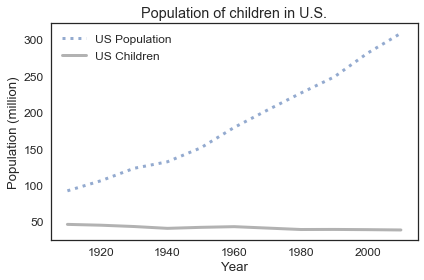

In [47]:
empty = TimeSeries()
fig1 = plot_results(population, childseries, 'Population of children in U.S.')


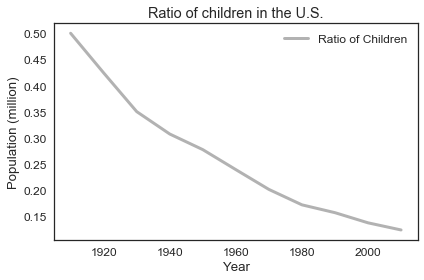

In [48]:
fig2 = plot_ratio(ratioseries, 'Ratio of children in the U.S.')

## Interpretation 
<bk> 
    The model above uses birth rates and child mortality rates to model the decline of child population in the United States. According to the model, the population of children shrunk from 46.14 million in 1910 to 38.47 million in 2010. The first model predicts that even as the population as a whole grows, the lower birth rate will cause the population of children to decrease. The second model, showing a ratio of the overall population to the child population, allows us to conclude that a decreased birth rate over time could easily lead to the declining population that we see today. 
<bk>
Although this model allows us to conclude that birth rate and mortality rate has a definite effect on the child population as a whole, it does not allow us to conclude decisively why the population of children is decreasing. 
<bk>
In the future, we could build a model that takes into account more parameters, such as immigration rate, and attempt to build a model that fits all facets of the data. We could also explore how different portions of the population, not just children, are aging and changing the demographics of our society. 
